# Források
https://www.tensorflow.org/tutorials/text/transformer

https://arxiv.org/pdf/2001.08317.pdf

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataStreamPreprocessor import DataStream, Normalizer, Batcher
import matplotlib.pyplot
import tensorflow as tf
import time

tf.random.set_seed(42) #======
np.random.seed(42)

'''
folder = str("../logs/20200706_15_03_03/") # error
folder = str("../logs/20200706_15_03_14/") # linear sho 312-123
folder = str("../logs/20200706_15_54_06/") # linear mid 59000-23000
folder = str("../logs/20200706_16_13_49/") # square mid 10000-3700
folder = str("../logs/20200706_16_14_42/") # squrae mid 87000-34000
folder = str("../logs/20200706_16_22_17/") # square mid 23000-8900 amorf
folder = str("../logs/20200707_11_46_33/") # linear sho 3500-1400
folder = str("../logs/20200707_12_32_33/") # error
folder = str("../logs/20200707_12_32_38/") # error
folder = str("../logs/20200707_12_32_41/") # error
folder = str("../logs/20200707_12_34_38/") # error
folder = str("../logs/20200707_13_12_55/") # error
folder = str("../logs/20200707_13_13_09/") # linear lon 136000-54000
folder = str("../logs/20200707_13_25_05/") # linear lon 120000-47000
folder = str("../logs/20200707_13_33_27/") # linear lon 120000-46000
folder = str("../logs/20200707_13_41_32/") # linear lon 130000-53000
folder = str("../logs/20200707_14_44_12/") # infini lon 340000-134000
folder = str("../logs/20200707_15_07_14/") # infini lon 370000-150000

folder = str("../logs/20200826_15_51_57/") # random sho 26655
folder = str("../logs/20200826_15_39_41/") # random sho 18464
folder = str("../logs/20200826_15_47_49/") # random sho 41667
folder = str("../logs/20200826_15_42_44/") # random sho 15481
folder = str("../logs/20200826_16_09_56/") # random mid 135798
''';

In [2]:
from ahrs.utils import WMM
wmm = WMM(latitude=10.0, longitude=-20.0, height=10.5)
wmm.magnetic_elements

{'X': 30580.589317329242,
 'Y': -4873.0379501479765,
 'Z': -2048.7415100030985,
 'H': 30966.41635479853,
 'F': 31034.11483566985,
 'I': -3.785178724663636,
 'D': -9.053999039068694,
 'GV': -9.053999039068694}

In [3]:
# Chose measurement pack
#folder = str("../logs/20200826_16_09_56/") # random lon 135798
#folder = str("../logs/20200826_15_42_44/") # random sho 15481
folder = str("../logs/20200826_15_47_49/") # random sho 41667
#folder = str("../logs/20200707_11_46_33/") # linear sho 3500-1400
#folder = str("../logs/20200706_16_14_42/") # squrae mid 87000-34000

d = DataStream(folder)

# If the measurement is too long or corrupt keep the middle of it
# d.keepData(0,66000)

print(d.data.shape)

(41667, 20)


In [4]:
# Plot data
d.plotData(plot3D = True)

In [5]:
# Input -Output signal options from MARG sensor and MoCap system
print('Choseable Features. Optional diff_ prestring.')
#print(d.data_header)
d.showHeader()

Choseable Features. Optional diff_ prestring.
0 - Timestamp
1 - AccX
2 - AccY
3 - AccZ
4 - GyroX
5 - GyroY
6 - GyroZ
7 - MagX
8 - MagY
9 - MagZ
10 - Marg_posX
11 - Marg_posY
12 - Marg_posZ
13 - Marg_quatX
14 - Marg_quatY
15 - Marg_quatZ
16 - Marg_quatW
17 - Marg_rotX
18 - Marg_rotY
19 - Marg_rotZ


In [6]:
d.addFeature(['diff_Timestamp', 'diff_Marg_posX', 'diff_Marg_posY', 'diff_Marg_posZ', 'diff_Marg_posX', 'diff_Marg_posY', 'diff_Marg_posZ'])

In [7]:
d.showHeader()

0 - Timestamp
1 - AccX
2 - AccY
3 - AccZ
4 - GyroX
5 - GyroY
6 - GyroZ
7 - MagX
8 - MagY
9 - MagZ
10 - Marg_posX
11 - Marg_posY
12 - Marg_posZ
13 - Marg_quatX
14 - Marg_quatY
15 - Marg_quatZ
16 - Marg_quatW
17 - Marg_rotX
18 - Marg_rotY
19 - Marg_rotZ
20 - diff_Timestamp
21 - diff_Marg_posX
22 - diff_Marg_posY
23 - diff_Marg_posZ
24 - diff_Marg_posX
25 - diff_Marg_posY
26 - diff_Marg_posZ


In [8]:
# Actual input and label data for the training. The columns defined in data_const will be constat in each sequence (first value)
inputs = [20,1,2,3,4,5,6,7,8,9,21,22,23]
#const_inputs = [-3,-2,-1]
const_inputs = []

labels = [24,25,26]

# Training parameters
input_size = len(inputs)
target_size = len(labels)
dropout_rate = 0.2

in_seq_len = 128
tar_seq_len = 1
batch_size = 16 

epochs = 10 

In [9]:
#=====================================Madgwick
Accdata =[1, 2, 3]        # ['AccX', 'AccY', 'AccZ']
Gyrodata=[4, 5, 6]        # ['GyroX', 'GyroY', 'GyroZ']
Magdata =[7, 8, 9]        # ['MagX', 'MagY', 'MagZ']
Quatdata=[13, 14, 15, 16] # ['Marg_quatW','Marg_quatX', 'Marg_quatY', 'Marg_quatZ'] #(w,x,y,z)

Acc_Madgwick, _, _, _  = d.dataParser(Accdata,  [], 1, const_inputs=const_inputs)
Gyro_Madgwick, _, _, _ = d.dataParser(Gyrodata, [], 1, const_inputs=const_inputs)
Mag_Madgwick, _, _, _  = d.dataParser(Magdata,  [], 1, const_inputs=const_inputs)

_, _, Quat_target, _= d.dataParser([], Quatdata, 1)

Acc_Madgwick  = Acc_Madgwick.reshape(len(Acc_Madgwick),3)
Gyro_Madgwick = Gyro_Madgwick.reshape(len(Gyro_Madgwick),3)
Mag_Madgwick  = Mag_Madgwick.reshape(len(Mag_Madgwick),3)

Quat_target=Quat_target.reshape(len(Quat_target),4)

print(Acc_Madgwick.shape, Gyro_Madgwick.shape, Mag_Madgwick.shape)


(41667, 3) (41667, 3) (41667, 3)


In [10]:
from ahrs import filters
adatok=filters.Madgwick(gyr=Gyro_Madgwick, acc=Acc_Madgwick, mag=Mag_Madgwick, Dt=0.004, gain=0.041)
adatok.Q.shape


(41667, 4)

In [11]:
type(adatok)

ahrs.filters.madgwick.Madgwick

In [12]:
print(adatok.Q)

[[ 0.74599472  0.12045248  0.1655276   0.63370632]
 [ 0.88136873  0.17129638  0.30915692  0.31347841]
 [ 0.89067552  0.19660648  0.40592173 -0.05718873]
 ...
 [ 0.6002488  -0.42073157  0.22045107  0.64349642]
 [ 0.09215235 -0.84707788  0.19067184  0.48745386]
 [ 0.09215235 -0.84707788  0.19067184  0.48745386]]


In [13]:
# Parsing the data
X_alap, X_header, _, _ = d.dataParser(inputs, [], in_seq_len, const_inputs=const_inputs)
_, _, Y_alap, Y_header = d.dataParser([], labels, tar_seq_len)
Y_alap=Y_alap[in_seq_len-1:,...].copy()

# Normalizing the data
nx = Normalizer(normtype='minmax')
ny = Normalizer(normtype='minmax')

X_norm = nx.normalize(X_alap)
Y_norm = ny.normalize(Y_alap)

X_norm[:,:,0] = X_alap[:,:,0] * 100

# Batching the data
batcher = Batcher(batch_size, shuffle=True)
X = batcher.batch(X_norm)
Y = batcher.batch(Y_norm)

#X = batcher.batch(X_alap)
#Y = batcher.batch(Y_alap)
#=====

Text(0.5, 1.0, 'Full measurement')

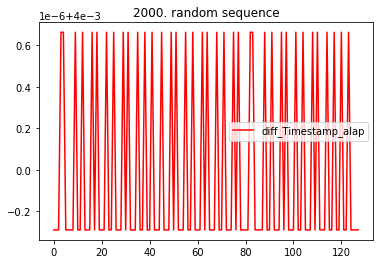

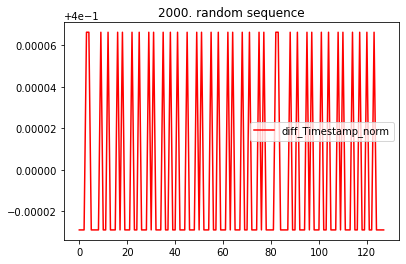

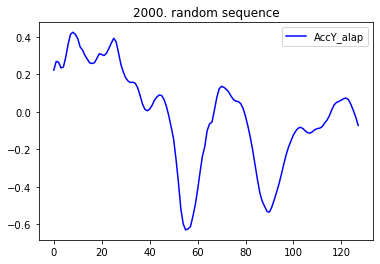

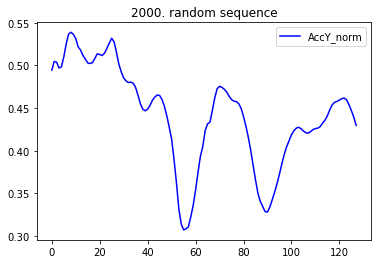

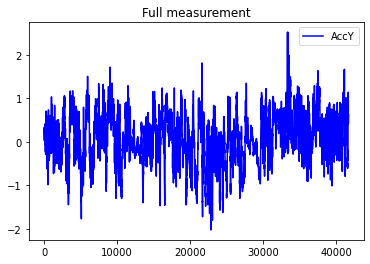

In [14]:
# Print a random sequece
#rand_seq = 15000 #==========
rand_seq = 2000
feature_0 = 0
feature_1 = 2

plt.figure()
plt.plot(X_alap[rand_seq, :, feature_0], color='red', label=(str(X_header[feature_0])+ '_alap'))
plt.legend()
plt.title(str(rand_seq) + '. random sequence')

plt.figure()
plt.plot(X_norm[rand_seq, :, feature_0], color='red', label=(str(X_header[feature_0])+ '_norm'))
plt.legend()
plt.title(str(rand_seq) + '. random sequence')

plt.figure()
plt.plot(X_alap[rand_seq, :, feature_1], color='blue', label=(str(X_header[feature_1])+ '_alap'))
plt.legend()
plt.title(str(rand_seq) + '. random sequence')

plt.figure()
plt.plot(X_norm[rand_seq, :, feature_1], color='blue', label=(str(X_header[feature_1])+ '_norm'))
plt.legend()
plt.title(str(rand_seq) + '. random sequence')

plt.figure()
plt.plot(d.data[:, feature_1], color='blue', label=str(d.data_header[feature_1]))
plt.legend()
plt.title('Full measurement')
# Notes:
# -1<Marg_quatW<1 , no neccesary need for normalization

In [15]:
 
class CNN(tf.keras.Model):
    def __init__(self, in_seq_len, in_size, target_size):
        super(CNN, self).__init__()
        self.c1_1 = tf.keras.layers.Conv1D(32,3,input_shape=(in_seq_len,in_size),activation='relu',padding="same")
        self.c1_2 = tf.keras.layers.Conv1D(32,3,activation='relu',padding="same")
        self.p1 = tf.keras.layers.Conv1D(64,5,strides=3,activation='relu',padding="valid")
        self.c2_1 = tf.keras.layers.Conv1D(64,3,activation='relu',padding="same")
        self.c2_2 = tf.keras.layers.Conv1D(64,3,activation='relu',padding="same")
        self.p2 = tf.keras.layers.Conv1D(128,3,strides=3,activation='relu',padding="valid")
        self.c3 = tf.keras.layers.Conv1D(128,3,activation='relu',padding="same")
        self.p3 = tf.keras.layers.Conv1D(256,14,strides=1,activation='relu',padding="valid")
        
        self.d1 = tf.keras.layers.Dense(512,activation='tanh')
        self.d2 = tf.keras.layers.Dense(target_size)
        
    def call(self, inp):
        x1=self.c1_1(inp)
        x2=self.c1_2(x1)
        x=self.p1(x1+x2)
        x1=self.c2_1(x)
        x2=self.c2_2(x1)
        x=self.p2(x1+x2)
        x=self.c3(x)
        x=self.p3(x)
        x=self.d1(x)
        x=self.d2(x)
        
        return x
        
        #loss 1e-5-el alakul

In [16]:
class CNN2(tf.keras.Model):
    def __init__(self, in_seq_len, in_size, target_size):
        super(CNN2, self).__init__()
        self.c1_1 = tf.keras.layers.Conv1D(32,3,input_shape=(in_seq_len,in_size),activation='relu',padding="same")
        self.c1_2 = tf.keras.layers.Conv1D(32,3,activation='relu',padding="same")
        self.c1_3 = tf.keras.layers.Conv1D(32,3,activation='relu',padding="same")
        self.p1 = tf.keras.layers.Conv1D(64,5,strides=3,activation='relu',padding="valid")
        self.c2_1 = tf.keras.layers.Conv1D(64,3,activation='relu',padding="same")
        self.c2_2 = tf.keras.layers.Conv1D(64,3,activation='relu',padding="same")
        self.c2_3 = tf.keras.layers.Conv1D(64,3,activation='relu',padding="same")
        self.p2 = tf.keras.layers.Conv1D(128,3,strides=3,activation='relu',padding="valid")
        self.c3_1 = tf.keras.layers.Conv1D(128,3,activation='relu',padding="same")
        self.c3_2 = tf.keras.layers.Conv1D(128,3,activation='relu',padding="same")
        self.c3_3 = tf.keras.layers.Conv1D(128,3,activation='relu',padding="same")
        self.p3 = tf.keras.layers.Conv1D(256,14,strides=1,activation='relu',padding="valid")
        
        self.d1 = tf.keras.layers.Dense(512,activation='tanh')
        self.d2 = tf.keras.layers.Dense(target_size)
        
    def call(self, inp):
        x1=self.c1_1(inp)
        x2=self.c1_2(x1)
        x3=self.c1_3(x2)
        x=self.p1(x1+x2+x3)
        
        x1=self.c2_1(x)
        x2=self.c2_2(x1)
        x3=self.c2_3(x2)
        x=self.p2(x1+x2+x3)
        
        x1=self.c3_1(x)
        x2=self.c3_2(x1)
        x3=self.c3_3(x2)
        x=self.p3(x1+x2+x3)
       
        x=self.d1(x)
        x=self.d2(x)
        
        return x
        # 1-e7 el egész jó
       

In [17]:
class CNN3(tf.keras.Model):
    def __init__(self, in_seq_len, in_size, target_size):
        super(CNN3, self).__init__()
        self.c1_1 = tf.keras.layers.Conv1D(16,3,input_shape=(in_seq_len,in_size),activation='relu',padding="same")
        self.c1_2 = tf.keras.layers.Conv1D(16,5,activation='relu',padding="same")
        self.c1_3 = tf.keras.layers.Conv1D(16,7,activation='relu',padding="same")
        self.p1 = tf.keras.layers.Conv1D(32,4,strides=2,activation='relu',padding="valid")
        self.c2_1 = tf.keras.layers.Conv1D(32,3,activation='relu',padding="same")
        self.c2_2 = tf.keras.layers.Conv1D(32,5,activation='relu',padding="same")
        self.c2_3 = tf.keras.layers.Conv1D(32,7,activation='relu',padding="same")
        self.p2 = tf.keras.layers.Conv1D(64,3,strides=3,activation='relu',padding="valid")
        self.c3_1 = tf.keras.layers.Conv1D(64,3,activation='relu',padding="same")
        self.c3_2 = tf.keras.layers.Conv1D(64,5,activation='relu',padding="same")
        self.c3_3 = tf.keras.layers.Conv1D(64,7,activation='relu',padding="same")
        self.p3 = tf.keras.layers.Conv1D(128,5,strides=2,activation='relu',padding="valid")
        self.c4_1 = tf.keras.layers.Conv1D(128,3,activation='relu',padding="same")
        self.c4_2 = tf.keras.layers.Conv1D(128,5,activation='relu',padding="same")
        self.c4_3 = tf.keras.layers.Conv1D(128,7,activation='relu',padding="same")
        self.p4 = tf.keras.layers.Conv1D(256,9,strides=1,activation='relu',padding="valid")
        
        
        self.d1 = tf.keras.layers.Dense(512,activation='tanh')
        self.d2 = tf.keras.layers.Dense(target_size)
        
    def call(self, inp):
        x1=self.c1_1(inp)
        x2=self.c1_2(x1)
        x2=self.c1_3(x2)
        x=self.p1(x1+x2)
        
        x1=self.c2_1(x)
        x1=self.c2_2(x1)
        x1=self.c2_3(x1)
        x=self.p2(x1+x)
        
        x1=self.c3_1(x)
        x1=self.c3_2(x1)
        x1=self.c3_3(x1)
        x=self.p3(x1+x)
       
        x1=self.c4_1(x)
        x1=self.c4_2(x1)
        x1=self.c4_3(x1)
        x=self.p4(x1+x)
       
        x=self.d1(x)
        x=self.d2(x)
        
        return x

In [18]:
class CNN4(tf.keras.Model):  #dilation + strided layers
    def __init__(self, in_seq_len, in_size, target_size):
        super(CNN4, self).__init__()
        self.c1_1 = tf.keras.layers.Conv1D(32,3,input_shape=(in_seq_len,in_size),activation='relu',padding="same")
        
        self.c1 = tf.keras.layers.Conv1D(32,3,activation='relu',padding="same")
        self.d1 = tf.keras.layers.Conv1D(32,2,dilation_rate=2,padding="causal")# elsső kérdés ez a kauzális padding s a rezdualitás ,megoldása
        self.p1 = tf.keras.layers.Conv1D(64,5,strides=3,activation='relu',padding="valid")
        
        self.c2 = tf.keras.layers.Conv1D(64,3,activation='relu',padding="same")
        self.d2 = tf.keras.layers.Conv1D(64,3,dilation_rate=2,padding="causal")
        self.p2 = tf.keras.layers.Conv1D(128,3,strides=3,activation='relu',padding="valid")
        
        self.c3 = tf.keras.layers.Conv1D(128,3,activation='relu',padding="same")
        self.d3 = tf.keras.layers.Conv1D(128,2,dilation_rate=2,padding="causal")
        self.p3 = tf.keras.layers.Conv1D(256,14,strides=1,activation='relu',padding="valid")
        
        self.l1 = tf.keras.layers.Dense(256,activation='tanh')
        self.l2 = tf.keras.layers.Dense(target_size)

    def call(self, inp):
        x=self.c1_1(inp)
        
        x1=self.c1(x)
        x1=self.d1(x1)
        x1=self.p1(x+x1)
        
        x2=self.c2(x1)
        x2=self.d2(x2)
        x2=self.p2(x2+x1)
        
        x3=self.c3(x2)
        x3=self.d3(x3)
        x3=self.p3(x2+x3)
        
        x4=self.l1(x3)
        x4=self.l2(x4)
        
        return x4
        

In [19]:
class WAVE1(tf.keras.Model):
    def __init__(self, in_seq_len, in_size, target_size):
        super(WAVE1, self).__init__()
        self.c1_1 = tf.keras.layers.Conv1D(16,3,input_shape=(in_seq_len,in_size),activation='relu',padding="same")
        
        self.c1 = tf.keras.layers.Conv1D(16,3,activation='relu',padding="same")
        self.p1 = tf.keras.layers.Conv1D(32,4,strides=4,activation='relu',padding="valid")
        self.c2 = tf.keras.layers.Conv1D(32,3,activation='relu',padding="same")
        self.p2 = tf.keras.layers.Conv1D(32,4,strides=4,activation='relu',padding="valid")
        self.c3 = tf.keras.layers.Conv1D(32,3,activation='relu',padding="same")
        self.p3 = tf.keras.layers.Conv1D(64,4,strides=4,activation='relu',padding="valid")
        self.c4 = tf.keras.layers.Conv1D(64,3,activation='relu',padding="same")
        self.p4 = tf.keras.layers.Conv1D(64,2,strides=2,activation='relu',padding="valid")
        #self.c5 = tf.keras.layers.Conv1D(64,3,activation='relu',padding="same")
        #self.p5 = tf.keras.layers.Conv1D(128,2,strides=2,activation='relu',padding="valid")
        #self.c6 = tf.keras.layers.Conv1D(128,3,activation='relu',padding="same")
        #self.p6 = tf.keras.layers.Conv1D(128,2,strides=2,activation='relu',padding="valid")
        #self.c7 = tf.keras.layers.Conv1D(128,3,activation='relu',padding="same")
        #self.p7 = tf.keras.layers.Conv1D(256,2,strides=2,activation='relu',padding="valid")
        
        self.d1 = tf.keras.layers.Dense(512,activation='tanh')
        self.d2 = tf.keras.layers.Dense(target_size)
  
    def call(self, inp):
        x=self.c1_1(inp)
        
        x1=self.c1(x)
        x=self.p1(x1+x)
        x1=self.c2(x)
        x=self.p2(x1+x)
        x1=self.c3(x)
        x=self.p3(x1+x)
        x1=self.c4(x)
        x=self.p4(x1+x)
        #x1=self.c5(x)
        #x=self.p5(x1+x)
        #x1=self.c6(x)
        #x=self.p6(x1+x)
        #x1=self.c7(x)
        #x=self.p7(x1+x)
       
        x=self.d1(x)
        x=self.d2(x)
        
        return x

In [20]:
class WAVE2(tf.keras.Model):
    def __init__(self, in_seq_len, in_size, target_size):
        super(WAVE2, self).__init__()
        self.c1_1 = tf.keras.layers.Conv1D(32,3,input_shape=(in_seq_len,in_size),activation='relu',padding="same")
        
        
        self.p1 = tf.keras.layers.Conv1D(32,2,dilation_rate=2,padding="causal")# elsső kérdés ez a kauzális padding s a rezdualitás ,megoldása
        self.c1 = tf.keras.layers.Conv1D(32,1,activation='relu',padding="same")        

        self.p2 = tf.keras.layers.Conv1D(32,2,dilation_rate=2,padding="causal")
        self.c2 = tf.keras.layers.Conv1D(32,1,activation='relu',padding="same")
        
        self.p3 = tf.keras.layers.Conv1D(32,2,dilation_rate=2,padding="causal")
        self.c3 = tf.keras.layers.Conv1D(32,1,activation='relu',padding="same")
    
        self.p4 = tf.keras.layers.Conv1D(32,2,dilation_rate=2,padding="causal")
        self.c4 = tf.keras.layers.Conv1D(32,1,activation='relu',padding="same")
    
        self.p5 = tf.keras.layers.Conv1D(32,2,dilation_rate=2,padding="causal")
        self.c5 = tf.keras.layers.Conv1D(32,1,activation='relu',padding="same")
        
        self.p6 = tf.keras.layers.Conv1D(32,2,dilation_rate=2,padding="causal")
        self.c6 = tf.keras.layers.Conv1D(32,1,activation='relu',padding="same")
    
        self.p7 = tf.keras.layers.Conv1D(32,2,dilation_rate=2,padding="causal")
        self.c7 = tf.keras.layers.Conv1D(32,1,activation='relu',padding="same")
        
        self.c8 = tf.keras.layers.Conv1D(256,1,activation='relu',padding="same")
        self.c9 = tf.keras.layers.Conv1D(target_size,1,padding="valid") #valahogy meg kéne oldani h 1 dim legyen
        
        self.d1 = tf.keras.layers.Dense(512,activation='tanh') #ez nem tudom kelle ide
        self.d2 = tf.keras.layers.Dense(target_size)
        
        self.softmax= tf.keras.layers.Softmax(input_shape=(in_seq_len,target_size))
        
    def call(self, inp):
            x=self.c1_1(inp)
            
            x1=self.p1(x)
            x1t=tf.keras.activations.tanh(x1)
            x1s=tf.keras.activations.sigmoid(x1)
            x1mul= tf.keras.layers.Multiply()([x1t, x1s])
            x1final=self.c1(x1mul)
            x1=x+x1final
            
            x2=self.p2(x1)
            x2t=tf.keras.activations.tanh(x2)
            x2s=tf.keras.activations.sigmoid(x2)
            x2mul= tf.keras.layers.Multiply()([x2t, x2s])
            x2final=self.c2(x2mul)
            x2=x1+x2final
            
            x3=self.p3(x2)
            x3t=tf.keras.activations.tanh(x3)
            x3s=tf.keras.activations.sigmoid(x3)
            x3mul= tf.keras.layers.Multiply()([x3t, x3s])
            x3final=self.c3(x3mul)
            x3=x2+x3final
            
            x4=self.p4(x3)
            x4t=tf.keras.activations.tanh(x4)
            x4s=tf.keras.activations.sigmoid(x4)
            x4mul= tf.keras.layers.Multiply()([x4t, x4s])
            x4final=self.c4(x4mul)
            x4=x3+x4final
            
            x5=self.p5(x4)
            x5t=tf.keras.activations.tanh(x5)
            x5s=tf.keras.activations.sigmoid(x5)
            x5mul= tf.keras.layers.Multiply()([x5t, x5s])
            x5final=self.c5(x5mul)
            x5=x4+x5final
            
            x6=self.p6(x5)
            x6t=tf.keras.activations.tanh(x6)
            x6s=tf.keras.activations.sigmoid(x6)
            x6mul= tf.keras.layers.Multiply()([x6t, x6s])
            x6final=self.c6(x6mul)
            x6=x5+x6final
            
            x7=self.p7(x6)
            x7t=tf.keras.activations.tanh(x7)
            x7s=tf.keras.activations.sigmoid(x7)
            x7mul= tf.keras.layers.Multiply()([x7t, x7s])
            x7final=self.c7(x7mul)
            
            
            x=x1final+x2final+x3final+x4final+x5final+x6final+x7final
            x=self.c8(x)
            x=self.c9(x)
            x=self.softmax(x)
            #x=self.d1(x)
            #x=self.d2(x)
            
            return x
            
            
            
            
  

In [21]:
x = tf.keras.backend.ones((16, 64))
y = tf.keras.backend.ones((64, 16))
xy = tf.keras.backend.dot(x, y)

In [22]:
class ConvNet(tf.keras.Model):
    def __init__(self,in_seq_len,in_size,target_size):
        super(ConvNet, self).__init__()
        self.c1_1 = tf.keras.layers.Conv1D(32,1,input_shape=(in_seq_len,in_size),activation='relu',padding="same")
        self.c1_2 = tf.keras.layers.Conv1D(64,3,activation='relu',padding="same")
        self.p1 = tf.keras.layers.MaxPool1D(2)
        self.c2 = tf.keras.layers.Conv1D(64,5,activation='relu',padding="same")
        self.p2 = tf.keras.layers.MaxPool1D(2)
        self.c3 = tf.keras.layers.Conv1D(128,7,activation='relu',padding="same")
        self.f = tf.keras.layers.GlobalAveragePooling1D()
        self.LSTM1  = tf.keras.layers.LSTM(32, return_sequences=True, activation = 'tanh',
                                           recurrent_activation = 'sigmoid', recurrent_dropout = 0,
                                           unroll = False, use_bias = True)
        self.LSTM2  = tf.keras.layers.LSTM(64, return_sequences=True, activation = 'tanh',
                                           recurrent_activation = 'sigmoid', recurrent_dropout = 0,
                                           unroll = False, use_bias = True)
        self.d1 = tf.keras.layers.Dense(128,activation='tanh')
        self.d2 = tf.keras.layers.Dense(target_size)
        
    def call(self, inp):
        x=self.c1_1(inp)
        x=self.c1_2(x)
        x=self.p1(x)
        x=self.c2(x)
        x=self.p2(x)
        x=self.c3(x)
        x = self.LSTM1(x)
        x = self.LSTM2(x)
        x = self.f(x)
        x=self.d1(x)
        x=self.d2(x)
        
        return x

In [23]:
class DenseNet(tf.keras.Model):
    def __init__(self,in_seq_len,in_size,target_size):
        super(DenseNet, self).__init__()
        
        self.inputdim=in_size*in_seq_len
        
        self.d1 = tf.keras.layers.Dense(self.inputdim,activation='relu')
        self.d2 = tf.keras.layers.Dense(128,activation='relu')
        self.d3 = tf.keras.layers.Dense(256,activation='relu')
        self.d4 = tf.keras.layers.Dense(512,activation='relu')
        self.d5 = tf.keras.layers.Dense(target_size,activation='relu')
        
    def call(self, inp):
        x = tf.reshape(inp,(tf.shape(inp)[0],self.inputdim))
        x=self.d1(x)
        x=self.d2(x)
        x=self.d3(x)
        x=self.d4(x)
        x=self.d5(x)
        
        return x

In [24]:
class LSTMnet(tf.keras.Model):
    def __init__(self, in_seq_len,in_size,target_size):
        super(LSTMnet, self).__init__()
        self.LSTM1  = tf.keras.layers.LSTM(64, input_shape=(in_seq_len,in_size), return_sequences=True, activation = 'tanh',
                                           recurrent_activation = 'sigmoid', recurrent_dropout = 0,
                                           unroll = False, use_bias = True)
        self.Dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.Dense2 = tf.keras.layers.Dense(target_size, activation=None)
        
    def call(self,inp):
        output = self.LSTM1(inp)
        output = self.Dense1(output)
        output = self.Dense2(output)
        
        return output

In [25]:
#lr_schedule= tf.keras.optimizers.schedules.ExponentialDecay(1e-5, decay_steps=10000, decay_rate=0.5,staircase=True)#====
#lr_schedule= tf.keras.optimizers.schedules.InverseTimeDecay(1e-5, decay_steps=3000, decay_rate=9,staircase=True)#====

#optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.98, epsilon=1e-9, )#======
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9, )

optimizer = tf.keras.optimizers.Nadam(1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9, )

In [26]:

def loss_function(real, pred):
    #return tf.reduce_mean(tf.math.square(real-pred))  #========
    return tf.reduce_sum(tf.math.square(real-pred))

train_loss = tf.keras.metrics.Mean(name='train_loss')

#========
def precision_function(inp, tar, prec):
    xprec=0
    yprec=0
    zprec=0
    truprec=0
    pred=transformer(inp)
    pool=tf.math.abs( tf.math.subtract (tar, pred))
    
    for i in range(len(pool[:,:])):
        if (pool[i,:,0] < prec):
            xprec=xprec+1
        if (pool[i,:,1] < prec):
            yprec=yprec+1
        if (pool[i,:,2] < prec):
            zprec=zprec+1
        if (pool[i,:,0]<prec and pool[i,:,1]<prec and pool[i,:,2]<prec ):
            truprec=truprec+1
    
    
    return xprec,yprec,zprec,truprec,len(pool[:,:])
    

In [27]:
# Net architecture
#transformer = DenseNet(in_seq_len,input_size,target_size)
#transformer = LSTMnet(in_seq_len,input_size,target_size)
#transformer = ConvNet(in_seq_len,input_size,target_size)
transformer = CNN3(in_seq_len,input_size,target_size)
#transformer = WAVE2(in_seq_len,input_size,target_size)

In [28]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

'''
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Checkpoint restored")
''';

In [29]:
train_step_signature =  [
    tf.TensorSpec(shape=(None, None, input_size), dtype=tf.float32),
    tf.TensorSpec(shape=(None, 1, target_size), dtype=tf.float32)
    ]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    with tf.GradientTape() as tape:
        predictions = transformer(inp)

        
        loss = loss_function(tar, predictions)
    
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    #optimizer.step()
    
    train_loss(loss)

In [30]:
# Training and feedback
losses=[]
#======

for epoch in range(epochs):
    stime = time.time()
    
    xp=0 #=======
    yp=0
    zp=0
    tp=0
    w=0
    
    train_loss.reset_states()
    h=0
    for batch in range(X.shape[0]):
        inp = X[batch]
        tar = Y[batch]
        
        #========
        xprec, yprec, zprec, truprec, whole = precision_function(inp, tar, 0.005)
        xp+=xprec
        yp+=yprec
        zp+=zprec
        tp+=truprec
        w+=whole
        
        train_step(inp, tar)
        
        if batch % 50 ==0:
            print('Epoch {} Batch {} Loss {:.5f}'.format(
            epoch+1, batch, train_loss.result()
            ))
            
    
    print('Epoch {} Precisions: x:{:.2f} %, y:{:.2f} %, z:{:.2f} %'.format(epoch+1, xp/w*100 , yp/w*100, zp/w*100)) #========
    print('Epoch {} True Precisions: {:.2f} %'.format(epoch+1, tp/w*100)) 
    
    if (epoch+1) %5 ==0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
   
    
    print ('Epoch {} Loss {:.5f}'.format(epoch + 1,  train_loss.result()))
    losses.append(train_loss.result())#=====

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - stime))
#========
timel=np.arange(epochs)+1
plt.plot(timel,losses)
        

Epoch 1 Batch 0 Loss 15.79386
Epoch 1 Batch 50 Loss 7.25137
Epoch 1 Batch 100 Loss 3.85442
Epoch 1 Batch 150 Loss 2.68658
Epoch 1 Batch 200 Loss 2.08665
Epoch 1 Batch 250 Loss 1.71691
Epoch 1 Batch 300 Loss 1.46820


KeyboardInterrupt: 

In [31]:
# Random prediction
stime=time.time()
idx = 1000
#inp = X_norm[idx].reshape((1,in_seq_len,input_size))
inp = X_alap[idx].reshape((1,in_seq_len,input_size)) #=====
tar_last = Y_alap[idx,-1,:]
pred = transformer(inp)
#denormed = ny.denormalize(pred)
denormed = pred #======
print("Predicted: ", np.array(denormed)[0],"\nReal:      ",tar_last)
print('\nPrediction time: ', time.time()-stime)


Predicted:  [[4.8847427 3.6220598 3.815497 ]] 
Real:       [-0.02951431  0.24060059  0.08825684]

Prediction time:  0.19809484481811523


In [32]:
Xdiff_pred = []
Ydiff_pred = []
Zdiff_pred = []
Xdiff_error = []
Ydiff_error = []
Zdiff_error = []

maxsteps = 500
idx = 0
times = np.arange(maxsteps)*0.004

for idx in range(maxsteps):
    #stime = time.time()
    inp = X_norm[idx].reshape((1,in_seq_len,input_size))
    tar_last = Y_alap[idx+in_seq_len,-1,:]
    pred = transformer(inp)
    denormed = np.array(ny.denormalize(pred)).flatten()
    #print(tar_last)
    #appendtime=time.time()
    Xdiff_pred.append(denormed[0])
    Ydiff_pred.append(denormed[1])
    Zdiff_pred.append(denormed[2])
    diff = denormed-tar_last
    Xdiff_error.append(diff[0])
    Ydiff_error.append(diff[1])
    Zdiff_error.append(diff[2])
    #print("Full: ",time.time()-stime,"  Append: ",time.time()-appendtime)

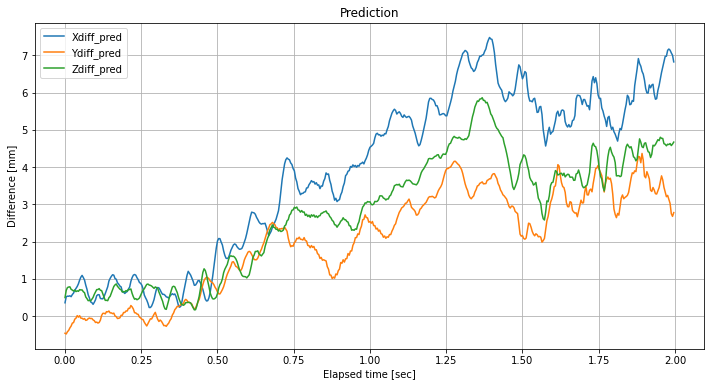

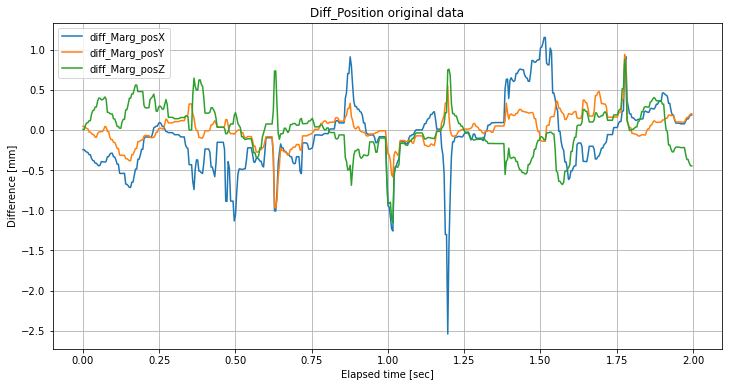

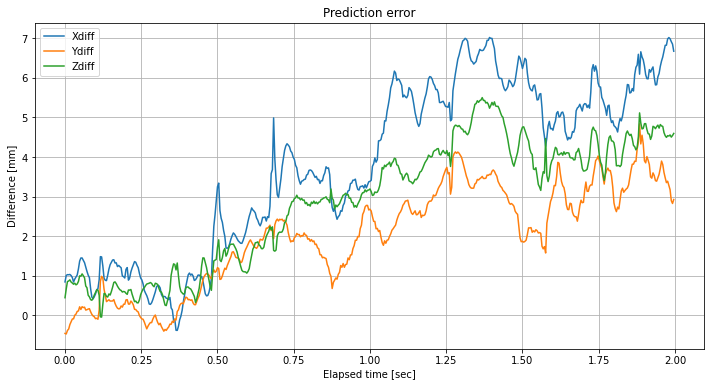

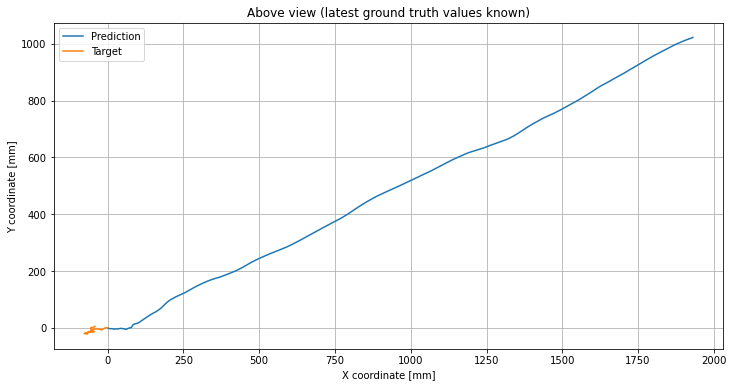

In [34]:
plt.figure(1,figsize=(12,6))
plt.title("Prediction")
plt.plot(times, Xdiff_pred, label='Xdiff_pred')
plt.plot(times, Ydiff_pred, label='Ydiff_pred')
plt.plot(times, Zdiff_pred, label='Zdiff_pred')
plt.ylabel("Difference [mm]")
plt.xlabel("Elapsed time [sec]")
plt.legend()
plt.grid()

plt.figure(2,figsize=(12,6))
plt.title("Diff_Position original data")
plt.plot(times, Y_alap[:maxsteps,0,0], label=str(Y_header[0]))
plt.plot(times, Y_alap[:maxsteps,0,1], label=str(Y_header[1]))
plt.plot(times, Y_alap[:maxsteps,0,2], label=str(Y_header[2]))
plt.ylabel("Difference [mm]")
plt.xlabel("Elapsed time [sec]")
plt.legend()
plt.grid()

plt.figure(3,figsize=(12,6))
plt.title("Prediction error")
plt.plot(times, Xdiff_error, label='Xdiff')
plt.plot(times, Ydiff_error, label='Ydiff')
plt.plot(times, Zdiff_error, label='Zdiff')
plt.ylabel("Difference [mm]")
plt.xlabel("Elapsed time [sec]")
plt.legend()
plt.grid()

x_pred = np.cumsum(Xdiff_pred)
y_pred = np.cumsum(Ydiff_pred)
x_tar = np.cumsum(Y_alap[:maxsteps,-1,0])
y_tar = np.cumsum(Y_alap[:maxsteps,-1,1])

plt.figure(4,figsize=(12,6))
plt.title("Above view (latest ground truth values known)")
plt.plot(x_pred,y_pred, label='Prediction')
plt.plot(x_tar,y_tar, label= 'Target')
plt.ylabel("Y coordinate [mm]")
plt.xlabel("X coordinate [mm]")
plt.legend()
plt.grid()

In [35]:
'''
Xdiff_pred = []
Ydiff_pred = []
Zdiff_pred = []
Xdiff_error = []
Ydiff_error = []
Zdiff_error = []

maxsteps = 500
idx = 0
times = np.arange(maxsteps)*0.004
tar = Y_norm[idx].reshape((1,tar_seq_len,target_size))
tar_inp = tar[:,:-1,:]

for idx in range(maxsteps):
    inp = X_norm[idx].reshape((1,in_seq_len,input_size))
    tar_last = Y_alap[idx,-1,:]
    pred = transformer(inp)
    denormed = np.array(ny.denormalize(pred)).flatten()
    Xdiff_pred.append(denormed[0])
    Ydiff_pred.append(denormed[1])
    Zdiff_pred.append(denormed[2])
    diff = denormed-tar_last
    if idx > 10:
        tar_inp=np.concatenate([tar_inp[:,1:,:],np.array(pred).reshape(1,1,-1)],axis=1)
    else:
        tar = Y_norm[idx].reshape((1,tar_seq_len,target_size))
        tar_inp = tar[:,:-1,:]
    Xdiff_error.append(diff[0])
    Ydiff_error.append(diff[1])
    Zdiff_error.append(diff[2])
''';

In [36]:
'''
plt.figure(1,figsize=(12,8))
plt.title("Prediction error (With initial ground truth only)")
plt.plot(times, Xdiff_error, label = 'Xdiff_error')
plt.plot(times, Ydiff_error, label = 'Ydiff_error')
plt.plot(times, Zdiff_error, label = 'Zdiff_error')
plt.ylabel("Error [mm]")
plt.xlabel("Elapsed time [sec]")
plt.legend()
plt.grid()


x_pred = np.cumsum(Xdiff_pred)
y_pred = np.cumsum(Ydiff_pred)
x_tar = np.cumsum(Y_alap[:maxsteps,-1,0])
y_tar = np.cumsum(Y_alap[:maxsteps,-1,1])
plt.figure(2,figsize=(12,8))
plt.title("Above view (With initial ground truth only)")
plt.plot(x_pred, y_pred, label= 'Prediction')
plt.plot(x_tar,y_tar, label= 'Target')
plt.ylabel("Y coordinate [mm]")
plt.xlabel("X coordinate [mm]")
plt.legend()
plt.grid()
''';